# Refresher on Backpropagating through Neural Networks
This will be based on the network decsribed in https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

In [2]:
def sigmoid_func(in_vec, derivative_of=False):
    if not derivative_of:
        return 1 / (1 + np.exp(-in_vec))
    base_value = sigmoid_func(in_vec, derivative_of=False)
    return np.multiply(base_value, (1 - base_value))

In [3]:
def relu_func(in_vec, derivative_of=False, out=None):
    if not derivative_of:
        if out is None:
            return np.maximum(in_vec, 0)
        np.maximum(in_vec, 0, out=out)
        return
    if out is None:
        out = np.copy(in_vec)
        out[out >= 0] = 1
        out[out < 0] = 0
        return out  
    else:
        np.copyto(out, in_vec)
        out[out > 0] = 1
        out[out <= 0] = 0
        return

In [126]:
def mean_squared_error(true_y, pred_y, derivative_of=False):
    if not derivative_of:
        return (1 / 2) * np.sum((true_y - pred_y) ** 2, axis=1)
    return pred_y - true_y

In [5]:
def stochastic_gradient_descent(orig_layer_w, layer_delta_w, learning_rate=0.1):
    return orig_layer_w - (learning_rate * layer_delta_w)

In [137]:
# Class global variables: 
# add_bias, networks_weights, layers_activations, batch_size, num_layers, network_value_cache
class BasicModel:
    def __init__(self, init_weights, layer_activations, add_bias=True, batch_size=None):
        if len(init_weights) != len(layer_activations):
            raise ValueError('Lengths of init_weights (' + str(len(init_weights)) + 
                             ') and layer_activations (' + str(len(layer_activations)) + 
                             ') not equal')
        self.add_bias = add_bias
        self.network_weights = np.copy(init_weights)
        self.layers_activations = np.copy(layer_activations)
        if batch_size is None:
            batch_size = 1
        self.batch_size = batch_size
        self.num_layers = len(init_weights)
        value_cache_layout = []
        for layer_weight_base in self.network_weights:
            output_shape = (batch_size, layer_weight_base.shape[0])
            zeros = [[0.] * layer_weight_base.shape[0]] * batch_size
            value_cache_layout.append([zeros, zeros])
        self.network_value_cache = value_cache_layout
    
    def forward_pass(self, in_vec):
        if len(in_vec.shape) == 1:
            output_cache = in_vec.reshape((1, in_vec.shape[0]))
        else:
            output_cache = np.copy(in_vec)
        self.input_cache = np.copy(output_cache)

        for i, (layer_weights, activation) in enumerate(zip(self.network_weights, self.layers_activations)):
            if self.add_bias:
                bias_terms = [1] * output_cache.shape[0]
                output_cache = np.column_stack((output_cache, bias_terms))
            self.network_value_cache[i][0] = np.matmul(output_cache, layer_weights.transpose())
            self.network_value_cache[i][1] = activation(self.network_value_cache[i][0])
            output_cache = self.network_value_cache[i][1]
        return self.network_value_cache[len(self.network_value_cache) - 1][1]
    
    def backward_pass(self, y_true):
        sigma_cache = []
        # Backprop last layer and calculate sigma oi's
        net_out, layer_out = self.network_value_cache[len(self.network_value_cache) - 1]
        div_E_out = layer_out - y_true
        div_out_net = self.layers_activations[len(self.layers_activations) - 1](net_out, derivative_of=True)
        div_E_net = np.multiply(div_E_out, div_out_net)   # This is the sigma for this layer
        sigma_cache.append(div_E_net)
        
        # Backprop through rest of layers
        num_hidden_layers = len(self.network_value_cache) - 1 # Subtract 1 because we take care of last layer already
        for i in reversed(range(0, num_hidden_layers)):
            net_out, layer_out = self.network_value_cache[i]
            div_E_out = np.matmul(
                sigma_cache[num_hidden_layers - i - 2],
                self.network_weights[i + 1][:, :-1], 
            )
            div_out_net = self.layers_activations[i](net_out, derivative_of=True)
            div_E_net = np.multiply(div_E_out, div_out_net)
            sigma_cache.append(div_E_net)
        sigma_cache = list(reversed(sigma_cache))
        
        # Forward through sigmas and w's to get dW's
        delta_w = []
        # Do first layer separately because using input X rather than previous layer output
        if self.add_bias:
            bias_terms = [1] * self.input_cache.shape[0]
            layer_input = np.column_stack((self.input_cache, bias_terms))
        else:
            layer_input = self.input_cache.transpose()
        div_E_w = np.matmul(sigma_cache[0].transpose(), layer_input)
        delta_w.append((1 / self.batch_size) * div_E_w)
        # Do the rest of the layers
        for i, layer_sigma in enumerate(sigma_cache[1:]):
            prev_net_out, prev_layer_out = self.network_value_cache[i]
            if self.add_bias:
                bias_terms = [1] * prev_layer_out.shape[0]
                layer_input = np.column_stack((prev_layer_out, bias_terms))
            else:
                layer_input = prev_layer_out
            div_E_w = np.matmul(layer_sigma.transpose(), layer_input)
            delta_w.append((1 / self.batch_size) * div_E_w)
        # Average over minibatch and return dW's
        return delta_w
    
    def predict(self, in_vec):
        if len(in_vec.shape) == 1:
            output_cache = in_vec.reshape((1, in_vec.shape[0]))
        else:
            output_cache = np.copy(in_vec)
        self.input_cache = np.copy(output_cache)

        for i, (layer_weights, activation) in enumerate(zip(self.network_weights, self.layers_activations)):
            if self.add_bias:
                bias_terms = [1] * output_cache.shape[0]
                output_cache = np.column_stack((output_cache, bias_terms))
            net_sum = np.matmul(output_cache, layer_weights.transpose())
            output_cache = activation(net_sum)
        return output_cache
    
    def update(self, delta_w, optimizer_func, lr):
        for i, layer_delta_w in enumerate(delta_w):
            self.network_weights[i] = optimizer_func(self.network_weights[i], layer_delta_w, lr)
    
    def fit_std(self, x, y_true, epochs=100, loss_function=None, optimizer_func=None, lr=0.1):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward_pass(x)
            loss_history.append(loss_function(y_true, y_pred))
            if (i % int(epochs / 4)) == 0:
                print('Epoch ' + str(i) + ' loss: ' + str(loss_history[len(loss_history) - 1]))
            d_w = self.backward_pass(y_true)
            self.update(d_w, optimizer_func, lr=lr)
        return loss_history

In [138]:
def plot_history(model_history):
    ax1, ax2 = plt.subplot(211), plt.subplot(212)
    ax1.plot(model_hist)
    ax1.set_xscale('log')
    ax1.set_ylabel('loss')
    ax2.plot(model_hist)
    ax2.set_yscale('log')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    plt.show()

## Small (2 layer) NN

In [15]:
# Starting weights
input_vec = np.array([.05,.1])
true_y = np.array([.01,.99])
w_h = np.array([
    [.15, .25, .35],
    [.2,  .30,  .35]
])
w_o = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [16]:
model = BasicModel(init_weights=[w_h, w_o], layer_activations=[sigmoid_func, sigmoid_func])

model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model.fit_std(
        x=input_vec, 
        y_true=true_y, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: [ 0.29839005]
Epoch 7500 loss: [  5.67232090e-06]
Epoch 15000 loss: [  5.64907152e-07]
Epoch 22500 loss: [  7.88482582e-08]
Epoch 30000 loss: [  1.22081756e-08]
Epoch 0 loss: [  1.22051804e-08]
Epoch 7500 loss: [  4.88190422e-09]
Epoch 15000 loss: [  1.96384730e-09]
Epoch 22500 loss: [  7.92871574e-10]
Epoch 30000 loss: [  3.20861358e-10]
Epoch 0 loss: [  3.20822696e-10]
Epoch 7500 loss: [  2.23519974e-10]
Epoch 15000 loss: [  1.55760756e-10]
Epoch 22500 loss: [  1.08561868e-10]
Epoch 30000 loss: [  7.56769253e-11]
Epoch 0 loss: [  7.56732850e-11]
Epoch 7500 loss: [  7.29919058e-11]
Epoch 15000 loss: [  7.04056304e-11]
Epoch 22500 loss: [  6.79110811e-11]
Epoch 30000 loss: [  6.55050005e-11]
Epoch 0 loss: [  6.55046855e-11]
Epoch 7500 loss: [  6.52688227e-11]
Epoch 15000 loss: [  6.50338099e-11]
Epoch 22500 loss: [  6.47996442e-11]
Epoch 30000 loss: [  6.45663225e-11]


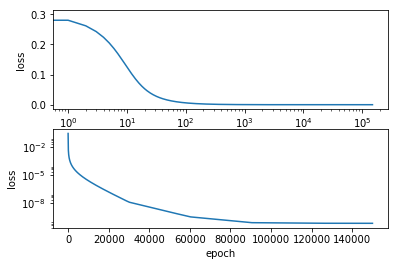

In [21]:
plot_history(model_hist)

In [22]:
y_pred = model.forward_pass(input_vec)
print('True y: ' + str(true_y))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [[ 0.01000853  0.98999249]]


## Larger (3 layer) 2->3->2->2 NN

In [13]:
# Starting weights
input_vec2 = np.array([.05,.1])
true_y2 = np.array([.01,.99])
w_h21 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h22 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o2 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [15]:
model_big = BasicModel(
    init_weights=[w_h21, w_h22, w_o2], 
    layer_activations=[sigmoid_func, sigmoid_func, sigmoid_func]
)

model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model_big.fit_std(
        x=input_vec2, 
        y_true=true_y2, 
        epochs=100001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: [ 0.30830438]
Epoch 25000 loss: [  1.81211777e-08]
Epoch 50000 loss: [  1.96869385e-11]
Epoch 75000 loss: [  2.24897203e-14]
Epoch 100000 loss: [  2.58142753e-17]
Epoch 0 loss: [  2.58072875e-17]
Epoch 25000 loss: [  8.76023955e-19]
Epoch 50000 loss: [  2.97861153e-20]
Epoch 75000 loss: [  1.01497461e-21]
Epoch 100000 loss: [  3.46839431e-23]
Epoch 0 loss: [  3.46787787e-23]
Epoch 25000 loss: [  8.99695719e-24]
Epoch 50000 loss: [  2.33760414e-24]
Epoch 75000 loss: [  6.04050618e-25]
Epoch 100000 loss: [  1.59646786e-25]
Epoch 0 loss: [  1.59642774e-25]
Epoch 25000 loss: [  1.59642774e-25]
Epoch 50000 loss: [  1.59642774e-25]
Epoch 75000 loss: [  1.59642774e-25]
Epoch 100000 loss: [  1.59642774e-25]
Epoch 0 loss: [  1.59642774e-25]
Epoch 25000 loss: [  1.59642774e-25]
Epoch 50000 loss: [  1.59642774e-25]
Epoch 75000 loss: [  1.59642774e-25]
Epoch 100000 loss: [  1.59642774e-25]


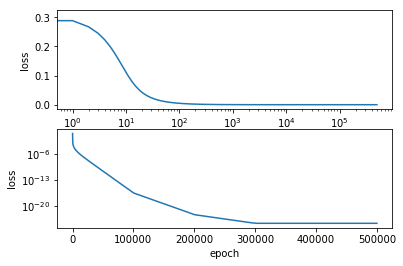

In [32]:
plot_history(model_hist)

In [33]:
y_pred = model_big.forward_pass(input_vec2)
print('True y: ' + str(true_y2))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [[ 0.01  0.99]]


In [34]:
model_big.network_weights

array([ array([[ 0.39828278,  0.29656556,  0.46565555],
       [ 0.69673126,  0.62346252,  0.26462525],
       [ 0.21480253,  0.39960506,  0.42605059]]),
       array([[ 0.41042405,  0.49537639,  0.92315088,  0.76628642],
       [ 0.46430831,  0.54896316,  0.5565346 ,  0.77261816]]),
       array([[-1.59381313, -1.45148161, -1.97847675],
       [ 1.55382308,  1.56165418,  1.91960895]])], dtype=object)

## ReLU Network

In [35]:
# Starting weights
input_vec3 = np.array([.05,.1])
true_y3 = np.array([.01,.99])
w_h31 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h32 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o3 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

### ReLU network dies with high Learning Rate

In [36]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.5, 0.01, 0.001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05
Epoch 0 loss: 5e-05
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05
Epoch 0 loss: 5e-05
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05


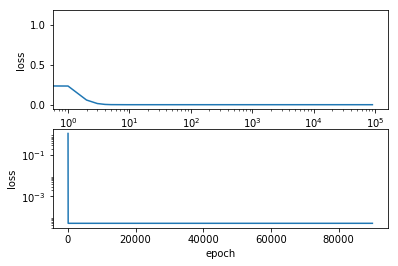

In [37]:
plot_history(model_hist)

### A more reasonable Learning Rate

In [38]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.01, 0.001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 3.55348669677e-30
Epoch 15000 loss: 3.55348669677e-30
Epoch 22500 loss: 3.55348669677e-30
Epoch 30000 loss: 3.55348669677e-30
Epoch 0 loss: 3.55348669677e-30
Epoch 7500 loss: 3.55348669677e-30
Epoch 15000 loss: 3.55348669677e-30
Epoch 22500 loss: 3.55348669677e-30
Epoch 30000 loss: 3.55348669677e-30


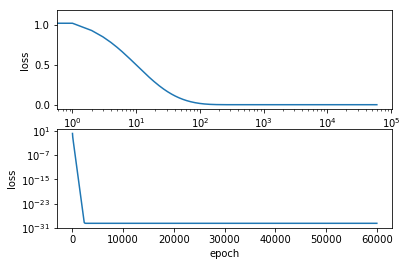

In [39]:
plot_history(model_hist)

### Learning Rate too low and it won't converge fast enough

In [40]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.001, 0.0001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 1.18937654076e-10
Epoch 15000 loss: 4.75537991571e-20
Epoch 22500 loss: 4.35122717723e-28
Epoch 30000 loss: 3.73333299911e-28
Epoch 0 loss: 3.73333299911e-28
Epoch 7500 loss: 3.73333299911e-28
Epoch 15000 loss: 3.73333299911e-28
Epoch 22500 loss: 3.73333299911e-28
Epoch 30000 loss: 3.73333299911e-28


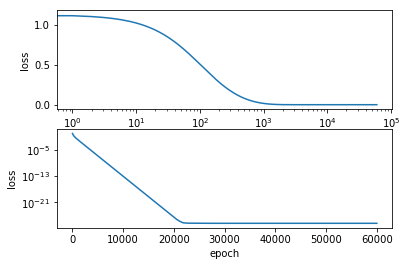

In [41]:
plot_history(model_hist)

# Mini-Batch NN

In [9]:
# Starting weights
input_vec4 = np.array([[.05,.1], [.1,.05]])
true_y4 = np.array([[.01,.99], [.99,.01]])
w_h41 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h42 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o4 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [13]:
model_big_batch = BasicModel(
    init_weights=[w_h41, w_h42, w_o4], 
    layer_activations=[relu_func, relu_func, relu_func],
    add_bias=True,
    batch_size=2
)

model_hist = []
for lr in [0.01, 0.001, 0.0001]:
    epoch_hist = model_big_batch.fit_std(
        x=input_vec4, 
        y_true=true_y4, 
        epochs=100001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: [ 1.12479929  1.30279685]
Epoch 25000 loss: [  2.25615461e-05   1.82584607e-05]
Epoch 50000 loss: [  7.56107883e-16   6.48873487e-16]
Epoch 75000 loss: [  3.01029552e-26   2.69033649e-26]
Epoch 100000 loss: [  6.61154786e-27   6.05812053e-27]
Epoch 0 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 25000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 50000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 75000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 100000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 0 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 25000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 50000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 75000 loss: [  6.61154786e-27   6.04471317e-27]
Epoch 100000 loss: [  6.61154786e-27   6.04471317e-27]


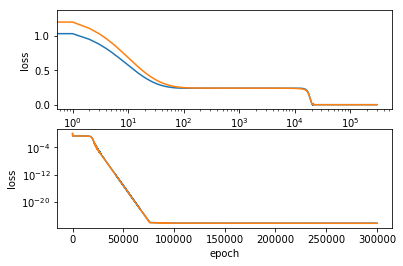

In [14]:
plot_history(model_hist)

# Forward pass output averaging (Experiment)

In [18]:
class IntermidAveragingModel(BasicModel):
    def __init(self, init_weights, layer_activations, add_bias=True, batch_size=None):
        # Because we are averaging is this case, we can always assume
        # Batch_size will alwasy act as 1 after the forward pass
        BasicModel.__init__(self, init_weights, layer_activations, add_bias=add_bias, batch_size=1)
    
    def reduce_batch(self, in_vec):
        return (1 / in_vec.shape[0]) * in_vec.sum(axis=0).reshape((1, in_vec.shape[1]))
    
    def forward_pass(self, in_vec):
        if len(in_vec.shape) == 1:
            output_cache = in_vec.reshape((1, in_vec.shape[0]))
        else:
            output_cache = np.copy(in_vec)
        self.input_cache = np.copy(output_cache)

        for i, (layer_weights, activation) in enumerate(zip(self.network_weights, self.layers_activations)):
            if self.add_bias:
                bias_terms = [1] * output_cache.shape[0]
                output_cache = np.column_stack((output_cache, bias_terms))
            self.network_value_cache[i][0] = np.matmul(output_cache, layer_weights.transpose())
            self.network_value_cache[i][1] = activation(self.network_value_cache[i][0])
            output_cache = self.network_value_cache[i][1]
        return self.network_value_cache[len(self.network_value_cache) - 1][1]
    
    def backward_pass(self, y_true):
        return BasicModel(self, self.reduce_batch(y_true))
    
    def 

In [19]:
# Starting weights
input_vec5 = np.array([[.05,.1], [.1,.05]])
true_y5 = np.array([[.01,.99], [.99,.01]])
w_h51 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h52 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o5 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [ ]:
intermid_model_big = IntermidAveragingModel(
    init_weights=[w_h51, w_h52, w_o5], 
    layer_activations=[relu_func, relu_func, relu_func],
    add_bias=True,
    batch_size=2
)

model_hist = []
for lr in [0.01, 0.001, 0.0001]:
    epoch_hist = model_big_batch.fit_std(
        x=input_vec5, 
        y_true=true_y5, 
        epochs=100001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

In [11]:
np.array([[1,2,3],[4,5,6]]).sum(axis=0).reshape((1,3))

array([[5, 7, 9]])

# Layered Model
This will use a similar sequential modeling idea as found in Keras

In [6]:
class SGD:
    def __init__(self, lr=0.01):
        self.learning_rate = lr
    
    def update_weights(self, orig_weights, delta_w):
        return orig_weights - (self.learning_rate * delta_w)

In [145]:
class DenseLayer:
    def __init__(self, input_feature_size, output_feature_size, activation_func, set_weight=None):
        self.activation_func = activation_func
        self.input_feature_size, self.output_feature_size = input_feature_size, output_feature_size
        self.weight_matrix_shape = (output_feature_size, input_feature_size + 1) # +1 for bias weights
        self.weights = set_weight
    
    # Weight_inits are of form (input_dim x output_dim)
    def model_set(self, batch_size, weight_inits):
        self.batch_size = batch_size
        self.input_cache = np.zeros((batch_size, self.input_feature_size), dtype=np.float64)
        self.net_cache = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        self.dv_out_net = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        self.sigmas = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        if self.weights is None:
            self.weights = np.copy(weight_inits)
        self.delta_w = np.zeros(self.weight_matrix_shape, dtype=np.float64)
    
    def forward(self, layer_input):
        np.copyto(self.input_cache, layer_input)
        self.biased_layer_input = np.column_stack((layer_input, [1] * layer_input.shape[0]))
        np.matmul(self.biased_layer_input, self.weights.transpose(), self.net_cache)
        return self.activation_func(self.net_cache, derivative_of=False)
    
    def backward(self, dv_E_out):
        self.activation_func(self.net_cache, derivative_of=True, out=self.dv_out_net)
        np.multiply(dv_E_out, self.dv_out_net, out=self.sigmas)
        np.matmul(self.sigmas.transpose(), self.biased_layer_input, out=self.delta_w)
        return np.matmul(self.sigmas, self.weights[:, :-1]) # Removing bias terms for dv_E_in of next layer
    
    def update(self, optimizer):
        self.weights = optimizer.update_weights(self.weights, (1. / self.batch_size) * self.delta_w)

In [135]:
class LayerModel:
    def __init__(self, batch_size=1):
        self.layers = []
        self.forward_input_cache = None
        self.batch_size = batch_size
    
    def add(self, in_layer):
        self.layers.append(in_layer)
    
    def compile_net(self):
        for layer in self.layers:
            w, h = layer.weight_matrix_shape
            init_weights = (np.random.rand(w, h) ) \
                                / math.sqrt(layer.input_feature_size)
            layer.model_set(self.batch_size, init_weights)
    
    def forward(self, in_vec):
        self.forward_input_cache = np.copy(in_vec)
        output_cache = self.forward_input_cache
        for layer in self.layers:
            output_cache = layer.forward(output_cache)
        self.output_cache = np.copy(output_cache)
        return output_cache
    
    def backward(self, y_true, loss_func):
        dv_E_out = loss_func(y_true, self.output_cache, derivative_of=True)
        for layer in reversed(self.layers):
            dv_E_out = layer.backward(dv_E_out)
        return dv_E_out
    
    def update(self, optimizer):
        for layer in self.layers:
            layer.update(optimizer)
    
    def fit_std(self, x, y_true, epochs=100, loss_function=None, optimizer=None):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward(x)
            loss_history.append(loss_function(y_true, y_pred))
            d_w = self.backward(y_true, loss_function)
            self.update(optimizer)
            if (i % int(epochs / 4)) == 0:
                print('Epoch ' + str(i) + ' loss: ' + str(loss_history[len(loss_history) - 1]))
        return loss_history

In [148]:
# Starting weights
input_vec = np.array([
    [.05,.1],
    [.10,.05]
])
true_y = np.array([
    [.01,.99],
    [.99,.01]
])
w_h = np.array([
    [.15, .25, .35],
    [.2,  .30,  .35]
])
w_o = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [150]:
model = LayerModel(batch_size=input_vec.shape[0])
model.add(DenseLayer(2, 3, relu_func))
model.add(DenseLayer(3, 2, relu_func))
model.add(DenseLayer(2, 2, relu_func))
model.compile_net()
model_hist = model.fit_std(input_vec, true_y, epochs=100000, loss_function=mean_squared_error, optimizer=SGD(lr=0.01))

Epoch 0 loss: [ 0.17377347  0.41631392]
Epoch 25000 loss: [  1.17312615e-11   1.21037313e-11]
Epoch 50000 loss: [  1.21511620e-26   1.26332887e-26]
Epoch 75000 loss: [  1.11990856e-27   1.22418264e-27]


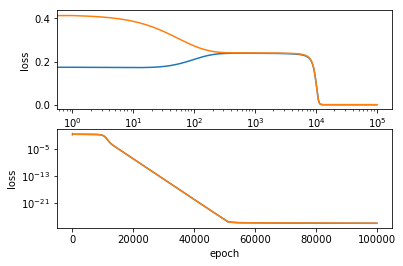

In [151]:
plot_history(model_hist)

# Convolutional Layer

In [ ]:
class Conv2DLayer:
    # input_feature_size should be tuple of (WxHxE)
    # kernel_shape should be tuple of (MxNxD)
    # set_weight should be numpy array of shape (MxNxD)
    def __init__(self, input_feature_size, kernel_shape, activation_func, set_weight=None):
        self.activation_func = activation_func
        self.input_feature_size, self.output_feature_size = input_feature_size, output_feature_size
        self.weight_matrix_shape = kernel_shape # TODO: does Conv need bias terms?
        self.weights = set_weight
    
    # Weight_inits are of form (input_dim x output_dim)
    def model_set(self, batch_size, weight_inits):
        self.batch_size = batch_size
        self.input_cache = np.zeros((batch_size, self.input_feature_size), dtype=np.float64)
        self.net_cache = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        self.dv_out_net = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        self.sigmas = np.zeros((batch_size, self.output_feature_size), dtype=np.float64)
        if self.weights is None:
            self.weights = np.copy(weight_inits)
        self.delta_w = np.zeros(self.weight_matrix_shape, dtype=np.float64)
    
    def forward(self, layer_input):
        np.copyto(self.input_cache, layer_input)
        self.biased_layer_input = np.column_stack((layer_input, [1] * layer_input.shape[0]))
        np.matmul(self.biased_layer_input, self.weights.transpose(), self.net_cache)
        return self.activation_func(self.net_cache, derivative_of=False)
    
    def backward(self, dv_E_out):
        self.activation_func(self.net_cache, derivative_of=True, out=self.dv_out_net)
        np.multiply(dv_E_out, self.dv_out_net, out=self.sigmas)
        np.matmul(self.sigmas.transpose(), self.biased_layer_input, out=self.delta_w)
        return np.matmul(self.sigmas, self.weights[:, :-1]) # Removing bias terms for dv_E_in of next layer
    
    def update(self, optimizer):
        self.weights = optimizer.update_weights(self.weights, (1. / self.batch_size) * self.delta_w)

# Dropout

# Batch Normalization